In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import os
import time
import datetime as dt
import packages.tools as tools
import packages.models as models
import statsmodels as sms
import statsmodels.tsa as tsa
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pmdarima as pm
import importlib

In [230]:
importlib.reload(models)

<module 'packages.models' from 'C:\\Users\\nvolf\\Google Drive 2\\5th Year (Masters) Modules\\Third Semester\\GitHub\\Nathaniel\\packages\\models.py'>

## Models:
We will use the following ARIMA models (primarily for benchmarking):
1. Univariate AR
2. Multivariate AR on $X_{\text{price},t}$ (i.e. univariate AR with exogenous predictors)
3. SARIMA
4. Multivariate SARIMA

If time permits, and if we encounter other ARIMA models of interest, then we will design implementations for these as well.

### Read in (pre-processed) dataset

In [68]:
path_dam_prices = "Datasets/DAMPrices.csv"

# Read in dataset
dam_prices = tools.read_price_data(path_dam_prices)

# Make adjustments for Daylight Savings Time (DST)
dam_prices = tools.price_dst_adjustment(dam_prices)

The two tables below show the original and 'preprocessed' price data, respectively.

In [69]:
pd.read_csv(path_dam_prices).head(3)

,AreaSet,AuctionDateTime,EURGBPRate,DeliveryPeriod,IntervalDuration,EURPrices
0,SEM-DA,2018-11-11 11:00:00,0.873668,2018-11-11 23:00:00,60,55.089
1,SEM-DA,2018-11-11 11:00:00,0.873668,2018-11-12 00:00:00,60,55.120
2,SEM-DA,2018-11-11 11:00:00,0.873668,2018-11-12 01:00:00,60,46.460


In [70]:
dam_prices.head(3)

,EURPrices
DeliveryPeriod,
2018-11-12 00:00:00,55.089
2018-11-12 01:00:00,55.120
2018-11-12 02:00:00,46.460


## Univariate: AR(p)

### First Step: Initial analysis

In [75]:
prices = dam_prices.copy()

In [76]:
def evaluate_stationarity(data, rolling_mean_window=5, rolling_std_window=5, acf_lags=50, pacf_lags=50, acf_vlines=[24,48],
                          pacf_vlines=[24,48], confidence=0.95):
    # Run ADF test for stationarity
    rolling_mean = data.dropna().rolling(rolling_mean_window).mean()
    rolling_std = data.dropna().rolling(rolling_std_window).std()
    ax = data.plot(figsize=(10,5))
    rolling_mean.plot(color='red', ax=ax)
    rolling_std.plot(color='blue', ax=ax)
    ax.legend(["Original Data", "Mean", "Standard Deviation"], loc='best')
    
    test = sm.tsa.adfuller(data.dropna())
    results = pd.Series(test[0:4], index=["Test statistic", "p-value", "No. of lags used", "No. of observations used"])
    for key, val in test[4].items():
        results[f"{key} critical value"] = val
    results["Best IC value"] = test[5]
    print("Augmented Dicky-Fuller Test Results:")    
    print(results)
    if test[1] > 1-confidence:
        print("Conclusion: Time series data is not stationary")
    else:
        print("Conclusion: Time series data is stationary")
    
    fig, ax1 = plt.subplots(1,2,figsize=(15,5))
    
    # Plot ACF
    sm.graphics.tsa.plot_acf(data.dropna(), ax=ax1[0], lags=acf_lags)
    if acf_vlines is not None:
        for lag in acf_vlines:
            ax1[0].axvline(lag, linestyle='--', linewidth=0.8, color='red')
    
    # Plot PACF
    sm.graphics.tsa.plot_pacf(data.dropna(), ax=ax1[1], lags=pacf_lags)
    if pacf_vlines is not None:
        for lag in pacf_vlines:
            ax1[1].axvline(lag, linestyle='--', linewidth=0.8, color='red')

Augmented Dicky-Fuller Test Results:
Test statistic             -7.898984e+00
p-value                     4.235033e-12
No. of lags used            4.100000e+01
No. of observations used    1.335000e+04
1% critical value          -3.430840e+00
5% critical value          -2.861757e+00
10% critical value         -2.566885e+00
Best IC value               9.489617e+04
dtype: float64
Conclusion: Time series data is stationary


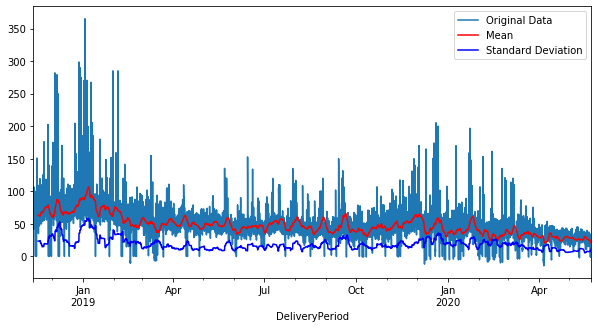

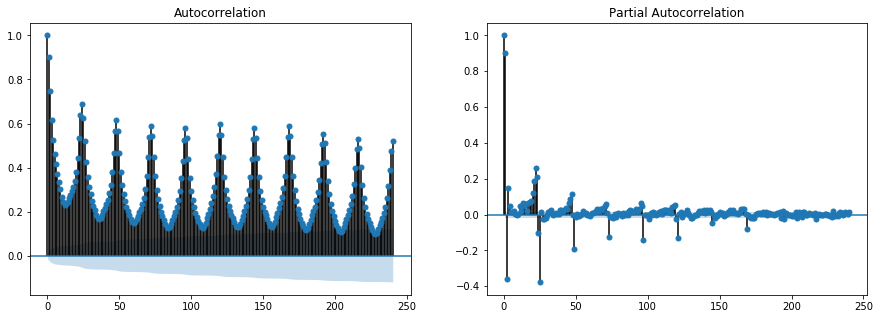

In [77]:
evaluate_stationarity(prices["EURPrices"], rolling_mean_window=120, rolling_std_window=120,
                      acf_lags=240, pacf_lags=240, acf_vlines=None, pacf_vlines=None)

In [78]:
prices["EURPrices_1h"] = prices["EURPrices"].diff()

Augmented Dicky-Fuller Test Results:
Test statistic                -26.218299
p-value                         0.000000
No. of lags used               41.000000
No. of observations used    13349.000000
1% critical value              -3.430840
5% critical value              -2.861757
10% critical value             -2.566885
Best IC value               94929.077500
dtype: float64
Conclusion: Time series data is stationary


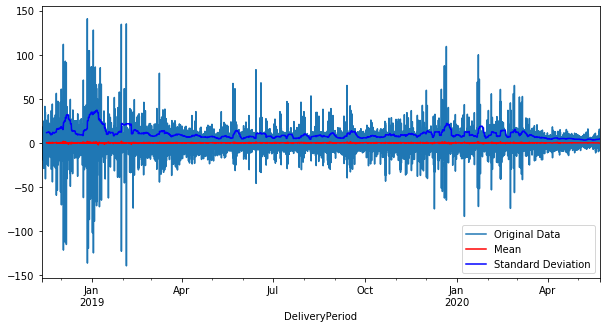

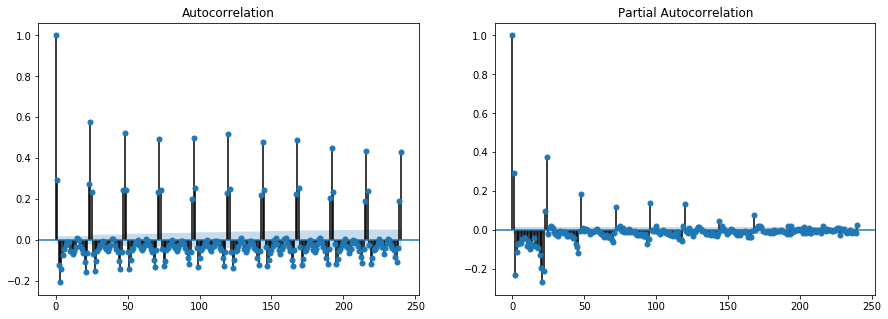

In [80]:
evaluate_stationarity(prices["EURPrices_1h"], rolling_mean_window=120, rolling_std_window=120,
                      acf_vlines=None, pacf_vlines=None, acf_lags=240, pacf_lags=240)

As expected, mean seems relatively constant (so no linear trend); variance of course is not, due to the price spikes. Although the ADF test shows stationarity, our job is far from over...

As expected from the generally known behaviour of electricity prices, the ACF shows weekly seasonality (peaks at lags 24 and 48, indicated by the red dashed vertical lines).

So, we will difference the data by 24 lags/hours.

In [81]:
prices["EURPrices_1h_24h"] = prices["EURPrices_1h"].diff(periods=24)

Augmented Dicky-Fuller Test Results:
Test statistic                -31.116291
p-value                         0.000000
No. of lags used               37.000000
No. of observations used    13329.000000
1% critical value              -3.430841
5% critical value              -2.861757
10% critical value             -2.566885
Best IC value               96265.059271
dtype: float64
Conclusion: Time series data is stationary


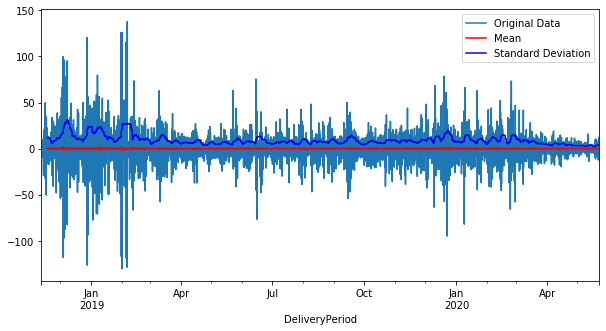

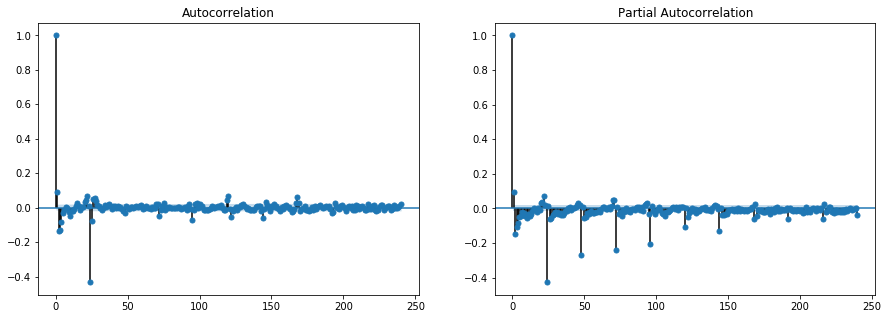

In [82]:
%matplotlib inline
evaluate_stationarity(prices["EURPrices_1h_24h"], rolling_mean_window=120, rolling_std_window=120,
                      acf_vlines=None, pacf_vlines=None, acf_lags=240, pacf_lags=240)

Augmented Dicky-Fuller Test Results:
Test statistic                 -34.084574
p-value                          0.000000
No. of lags used                36.000000
No. of observations used     13306.000000
1% critical value               -3.430842
5% critical value               -2.861757
10% critical value              -2.566886
Best IC value               106005.593757
dtype: float64
Conclusion: Time series data is stationary


C:\Users\nvolf\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


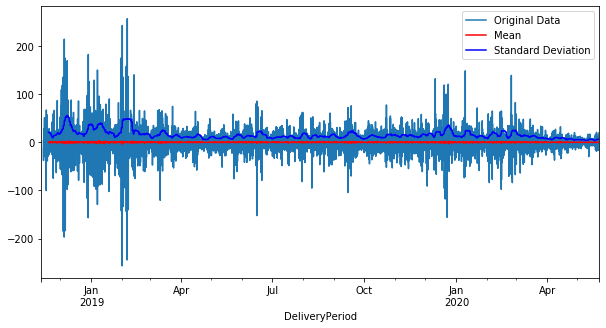

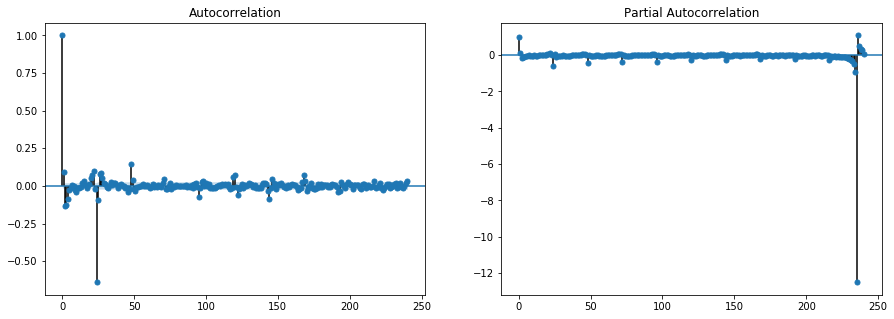

In [83]:
prices["EURPrices_1h_24h_24h"] = prices["EURPrices_1h_24h"].diff(periods=24)
evaluate_stationarity(prices["EURPrices_1h_24h_24h"], rolling_mean_window=120, rolling_std_window=120,
                      acf_vlines=None, pacf_vlines=None, acf_lags=240, pacf_lags=240)

Data looks a bit better, but there is still some seasonal behaviour at lag 24.

Augmented Dicky-Fuller Test Results:
Test statistic                -31.116291
p-value                         0.000000
No. of lags used               37.000000
No. of observations used    13329.000000
1% critical value              -3.430841
5% critical value              -2.861757
10% critical value             -2.566885
Best IC value               96265.059271
dtype: float64
Conclusion: Time series data is stationary


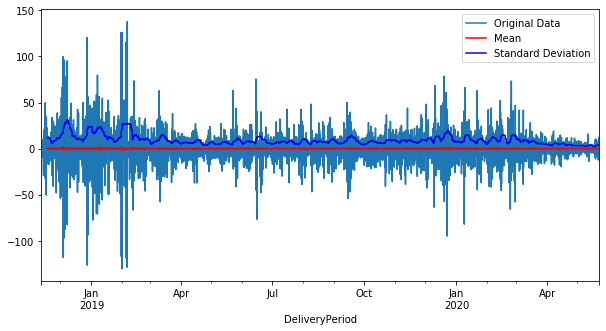

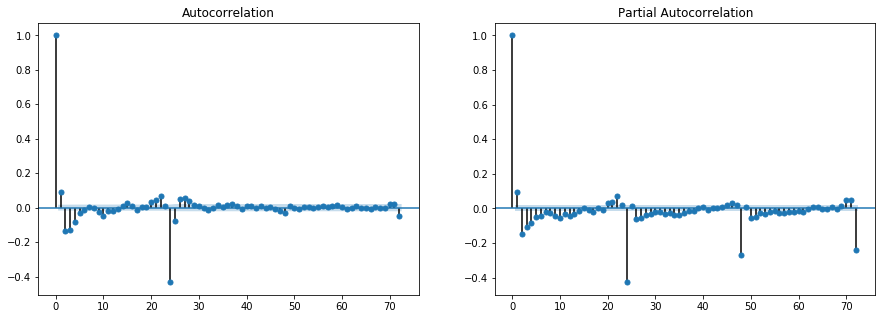

In [84]:
evaluate_stationarity(prices["EURPrices_1h_24h"], rolling_mean_window=120, rolling_std_window=120,
                      acf_vlines=None, pacf_vlines=None, acf_lags=72, pacf_lags=72)

Any further differencing doesn't seem to be useful.

Obviously (I think), this indicates that there are several dependencies that occur over days (not so much hours). After one hour differencing, most of the remaining correlation then seemed to come from a few hours before and from whole days before.

Therefore, I expect that when we train our AR(p) model, the strongest parameters affecting $t$ would be parameters $t-1, t-2, t-3, t-4$ and no further, as well as $(t-24n), n \in \mathbb{N}$ and from the hours near $(t-24n)$.

### Second Step: Finding the optimal parameter $p$

For this, we will be making use of the `statsmodels.tsa` function `AutoReg()` which fits an autoregressive (AR) time series model. But first, in order to find the optimal AR(p) model, we will need to fit an AR model for all lag combinations. However, we cannot check every parameter since there would be $2^{700}$ models to check. It wouldn't be computationally feasible. Instead, we check 700 models, i.e. AR(1), AR(2), AR(3), ..., AR(700).

It so happens that `statsmodels.tsa` has another function, `ar_select_order()` which helps to determine the optimal AR model as outlined above, so we will see if this function will be useful for us.

In [19]:
start = time.time()
test_ar = tsa.ar_model.ar_select_order(prices["EURPrices"], maxlag=700, trend='ct')
print(f"Execution time: {time.time() - start} seconds")

C:\Users\nvolf\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: 

Execution time is still a bit long (more than 10 minutes), so we will just go with fitting an AR(700) model as in the paper and make a note of the parameters, as it wouldn't be feasible for example when we run the walk-forward evluation method which will require the running of the above line of code (among several other lines of code) at least a few hundred times.

In [63]:
test_ar.ar_lags

NameError: name 'test_ar' is not defined

The ar_select_order() function found the AR(121) to be the best in terms of its BIC criterion

In [20]:
test_ar1 = tsa.ar_model.AutoReg(prices["EURPrices"], lags=1)
type(test_ar1)

C:\Users\nvolf\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


statsmodels.tsa.ar_model.AutoReg

In [21]:
"""
Parameters:
    data: pd.DataFrame
    target: datetime
    p: int
        AR model parameter
    trend: str
    forecast_steps: int
"""

def AR_univariate(data, target, p, trend='ct', forecast_steps=24):
    if "AuctionDateTime" in data.columns:
        data = data.drop("AuctionDateTime", axis=1)
    
    if type(target) == str:
        target = dt.datetime.strptime(target, "%Y-%m-%d")
    
    # Fit AR(p) model to data
    ar_model = tsa.ar_model.AutoReg(endog=data, lags=p, trend=trend).fit()
    
    # Make forecasts
    forecast = ar_model.predict(start=target, end=target+dt.timedelta(hours=forecast_steps-1))
    
    # Create and prepare forecasts dataframe
    forecast_df = pd.DataFrame(dict(EURPrices=forecast), columns=["EURPrices"])
    forecast_df.index = pd.date_range(target, periods=forecast.shape[0], freq="H")
    forecast_df.index.name = "DeliveryPeriod"

    return(forecast_df)

In [22]:
AR_univariate(dam_prices, dt.datetime.strptime("2020-05-22", "%Y-%m-%d"), 700)
# AR_univariate(dam_prices, dt.datetime.strptime("2018-11-12", "%Y-%m-%d"), 700)

C:\Users\nvolf\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,EURPrices
DeliveryPeriod,
2020-05-22 00:00:00,8.786579
2020-05-22 01:00:00,-0.943705
2020-05-22 02:00:00,-0.327700
2020-05-22 03:00:00,0.777120
2020-05-22 04:00:00,0.874274
2020-05-22 05:00:00,1.560757
2020-05-22 06:00:00,1.618999
2020-05-22 07:00:00,5.118121
2020-05-22 08:00:00,7.084591


## Multivariate: VAR(p)

In [272]:
"""
Parameters:
    data: pd.DataFrame
    target: datetime
    p: int
        AR model parameter
    trend: str
    forecast_steps: int
"""

def AR_multivariate(data, target, p=None, forecast_steps=24):
    # Not yet sure how to allow for fetching fitted values (in-sample forecasts)
    data_copy = data.copy()
    if "AuctionDateTime" in data.columns:
        data_copy.drop("AuctionDateTime", axis=1, inplace=True)
    
    # Reformat data to pass into VAR
    data_new = pd.DataFrame(index=pd.unique(data_copy.index.date))
    
    for column in range(24):
        new_column = data_copy.loc[data_copy.index.hour==column]
        new_column.index = new_column.index.date
        data_new.insert(data_new.shape[1], column, new_column)
    
    data_new.index = pd.to_datetime(data_new.index)
    data_new = data_new.asfreq('d').loc[data_new.notna().all(axis=1)]
    
    # Fit VAR(p) model to data
    var_model = tsa.vector_ar.var_model.VAR(endog=data_new, dates=data_new.index, freq='d')
    
    if p is None:
        p = max(var_model.select_order().selected_orders.values())

    var_fit = var_model.fit(maxlags=p)
    
    # Make forecasts
    target = data_new.index[-1] + dt.timedelta(days=1)
    forecast = var_fit.forecast(y=data_new.values, steps=1).flatten()
    
    # Create and prepare forecasts dataframe
    forecast_df = pd.DataFrame(dict(EURPrices=forecast), columns=["EURPrices"])
    forecast_df.index = pd.date_range(target, periods=len(forecast), freq="H")
    forecast_df.index.name = "DeliveryPeriod"

    return(var_fit, forecast_df)

In [273]:
var_fit, forecast = AR_multivariate(dam_prices, "", p=30)

In [274]:
var_fit, forecast = AR_multivariate(dam_prices, "")

In [275]:
models.AR_multivariate(dam_prices, "", p=30)

,EURPrices
DeliveryPeriod,
2020-05-23 00:00:00,-2.910381
2020-05-23 01:00:00,-7.946550
2020-05-23 02:00:00,-10.810815
2020-05-23 03:00:00,-19.053703
2020-05-23 04:00:00,-19.143082
2020-05-23 05:00:00,-21.046740
2020-05-23 06:00:00,-25.437088
2020-05-23 07:00:00,-17.767055
2020-05-23 08:00:00,-8.824602


In [278]:
test1 = AR_univariate(dam_prices, dt.datetime.strptime("2020-05-22", "%Y-%m-%d"), 700)

_, test2 = AR_multivariate(dam_prices.iloc[0:-24], "", 50)
test1.insert(1,"Multi_50",test2)

vm, test3 = AR_multivariate(dam_prices.iloc[0:-24], "")
test1.insert(1,f"Multi_{vm.k_ar}",test3)

_, test4 = AR_multivariate(dam_prices.iloc[0:-24], "", 1)
test1.insert(1,"Multi_1",test4)

test_df = test1
test_df.columns = ["Uni", "Multi_1","Multi_18","Multi_50"]

C:\Users\nvolf\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


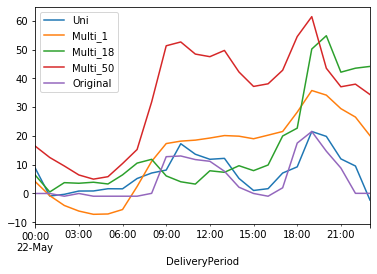

In [279]:
test_df["Original"] = dam_prices.loc["2020-05-22"]["EURPrices"]
test_df.plot()